# Interacting with Contrastive Language-Image Pre-Training (CLIP) model on AMD GPU

## Introduction 
Contrastive Language-Image Pre-Training (CLIP) is a multimodal deep learning model that bridges vision and natural language. It was introduced in the paper “[Learning Transferrable Visual Models from Natural Language Supervision](https://arxiv.org/abs/2103.00020)” (2021) from OpenAI, and it was trained contrastively on a huge amount (400 million) of web scraped data of image-caption pairs (one of the first models to do this). 

During the pre-training phase, CLIP is trained to predict the semantic associations between images and texts within a batch. This involves determining which image-text pairs are most closely related or relevant to each other. The objective is to maximize the cosine similarity between the embeddings of image and text pairs in the batch while minimizing the similarity of embeddings for incorrect pairs. The model achieves this by learning a multi-modal embedding space. A symmetric cross entropy loss is optimized over these similarity scores. 

![CLIP structure](https://production-media.paperswithcode.com/methods/3d5d1009-6e3d-4570-8fd9-ee8f588003e7.png)

Image source: [Learning Transferable Visual Models From Natural Language Supervision](https://arxiv.org/abs/2103.00020).

CLIP can be fine-tuned for various tasks, such as image classification and cross-modal applications, making it a powerful tool for multimodal AI. 

In the subsequent sections of the blog, we will leverage the **PyTorch** framework along with **ROCm** to run CLIP models. Our objectives include:
- calculate the similarity between arbitrary image and text inputs
- conduct zero-shot image classifications 

### Setup:
This demo was creating using the following settings. For comprehensive support details, please refer to the [ROCm documentation](https://rocm.docs.amd.com/projects/install-on-linux/en/latest/).

* Hardware & OS:
  * [AMD Instinct GPU](https://www.amd.com/en/products/accelerators/instinct.html)
  * Ubuntu 22.04.3 LTS
* Software:
  * [ROCm 5.7.0+](https://rocm.docs.amd.com/en/latest/)
  * [Pytorch 2.0+](https://pytorch.org/)

## Similarity calculation between arbitrary image and text inputs
### Step 1: Getting started

First, let's confirm the availability of the GPU.

In [1]:
!rocm-smi --showproductname



========================= ROCm System Management Interface =========================
=================================== Product Info ===================================
GPU[0]		: Card series: 		AMD INSTINCT MI250 (MCM) OAM AC MBA
GPU[0]		: Card model: 		0x0b0c
GPU[0]		: Card vendor: 		Advanced Micro Devices, Inc. [AMD/ATI]
GPU[0]		: Card SKU: 		D65209
=============================== End of ROCm SMI Log ================================


Next, install CLIP and the required libraries.

In [2]:
! pip install git+https://github.com/openai/CLIP.git
! pip install ftfy regex tqdm matplotlib

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-8t4h9mh4
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-8t4h9mh4
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done


### Step 2: Load the model

Before loading the model we can use `clip.available_models()` to list the names of available CLIP models.

In [3]:
import numpy as np
import torch
import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

Various CLIP models come with distinct configurations for their vision and text encoders. In this context, we'll load the model "ViT-L/14@336px", which is the biggest one among the above models, and check its configuration.  

In [4]:
model, preprocess = clip.load("ViT-L/14@336px")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 427,944,193
Input resolution: 336
Context length: 77
Vocab size: 49408


### Step 3: Check the image preprocessing

We resize the input images and center-crop them to conform with the image resolution that the model expects. Before doing so, we will normalize the pixel intensity using the dataset mean and standard deviation.

The second return value from `clip.load()` contains a torchvision `Transform` that performs this preprocessing.

In [5]:
preprocess

Compose(
    Resize(size=336, interpolation=bicubic, max_size=None, antialias=warn)
    CenterCrop(size=(336, 336))
    <function _convert_image_to_rgb at 0x7f9def775990>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

### Step 4: Check the Text preprocessing

We use a case-insensitive tokenizer, which can be invoked using `clip.tokenize()`. By default, the outputs are padded to become 77 tokens long, which is what the CLIP model expects.

In [6]:
clip.tokenize("Hello World!")

tensor([[49406,  3306,  1002,   256, 49407,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)

### Step 5: Set up input images and texts

We are going to feed 8 sample images from the test set provided by [skimage](https://scikit-image.org/docs/stable/api/skimage.data.html) and their textual descriptions to the model, and compare the similarity between the corresponding features.

The tokenizer is case-insensitive, and we can freely give any suitable textual descriptions.

In [7]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from collections import OrderedDict
import torch

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# use images from skimage and their textual descriptions
descriptions = {
    "page": "a page of text about segmentation",
    "chelsea": "a facial photo of a tabby cat",
    "astronaut": "a portrait of an astronaut with the American flag",
    "rocket": "a rocket standing on a launchpad",
    "motorcycle_right": "a red motorcycle standing in a garage",
    "camera": "a person looking at a camera on a tripod",
    "horse": "a black-and-white silhouette of a horse", 
    "coffee": "a cup of coffee on a saucer"
}

Display the eight images alongside their respective textual descriptions.

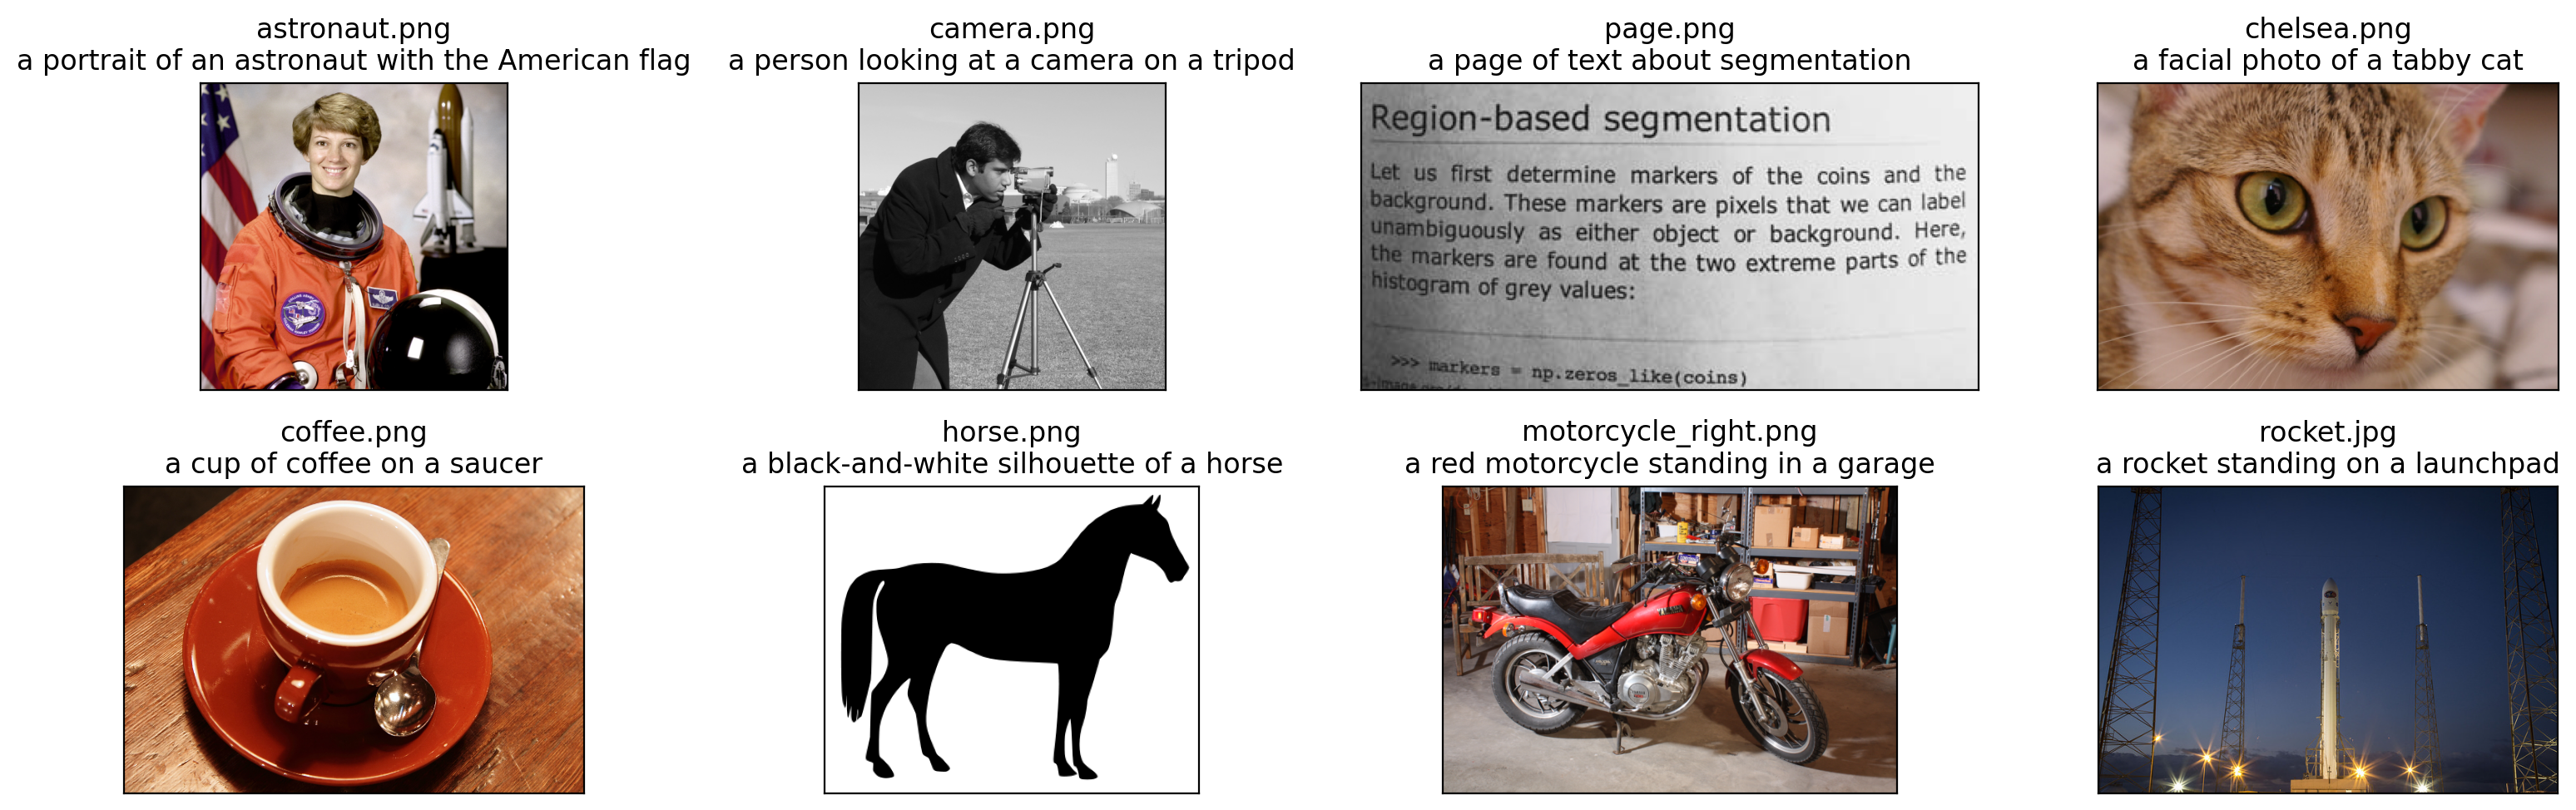

In [8]:
original_images = []
images = []
texts = []
plt.figure(figsize=(16, 5))

for filename in [filename for filename in os.listdir(skimage.data_dir) if filename.endswith(".png") or filename.endswith(".jpg")]:
    name = os.path.splitext(filename)[0]
    if name not in descriptions:
        continue

    image = Image.open(os.path.join(skimage.data_dir, filename)).convert("RGB")
  
    plt.subplot(2, 4, len(images) + 1)
    plt.imshow(image)
    plt.title(f"{filename}\n{descriptions[name]}")
    plt.xticks([])
    plt.yticks([])

    original_images.append(image)
    images.append(preprocess(image))
    texts.append(descriptions[name])

plt.tight_layout()


### Step 6: Generate features

Next we perform image normalization, tokenize each text input using a case-insensitive tokenizer, and then execute the forward pass of the model. This process yields the respective image and text features, which are crucial representations for subsequent tasks or analyses within the CLIP framework.

In [9]:
image_input = torch.tensor(np.stack(images)).cuda()
text_tokens = clip.tokenize(["This is " + desc for desc in texts]).cuda()

In [10]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

### Step 7: Calculate similarity score between text and images
We normalize the features and calculate the dot product of each pair.

In [11]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

### Step 8: Visualize the similarity between text and images

Text(0.5, 1.0, 'Similarity between text and image features')

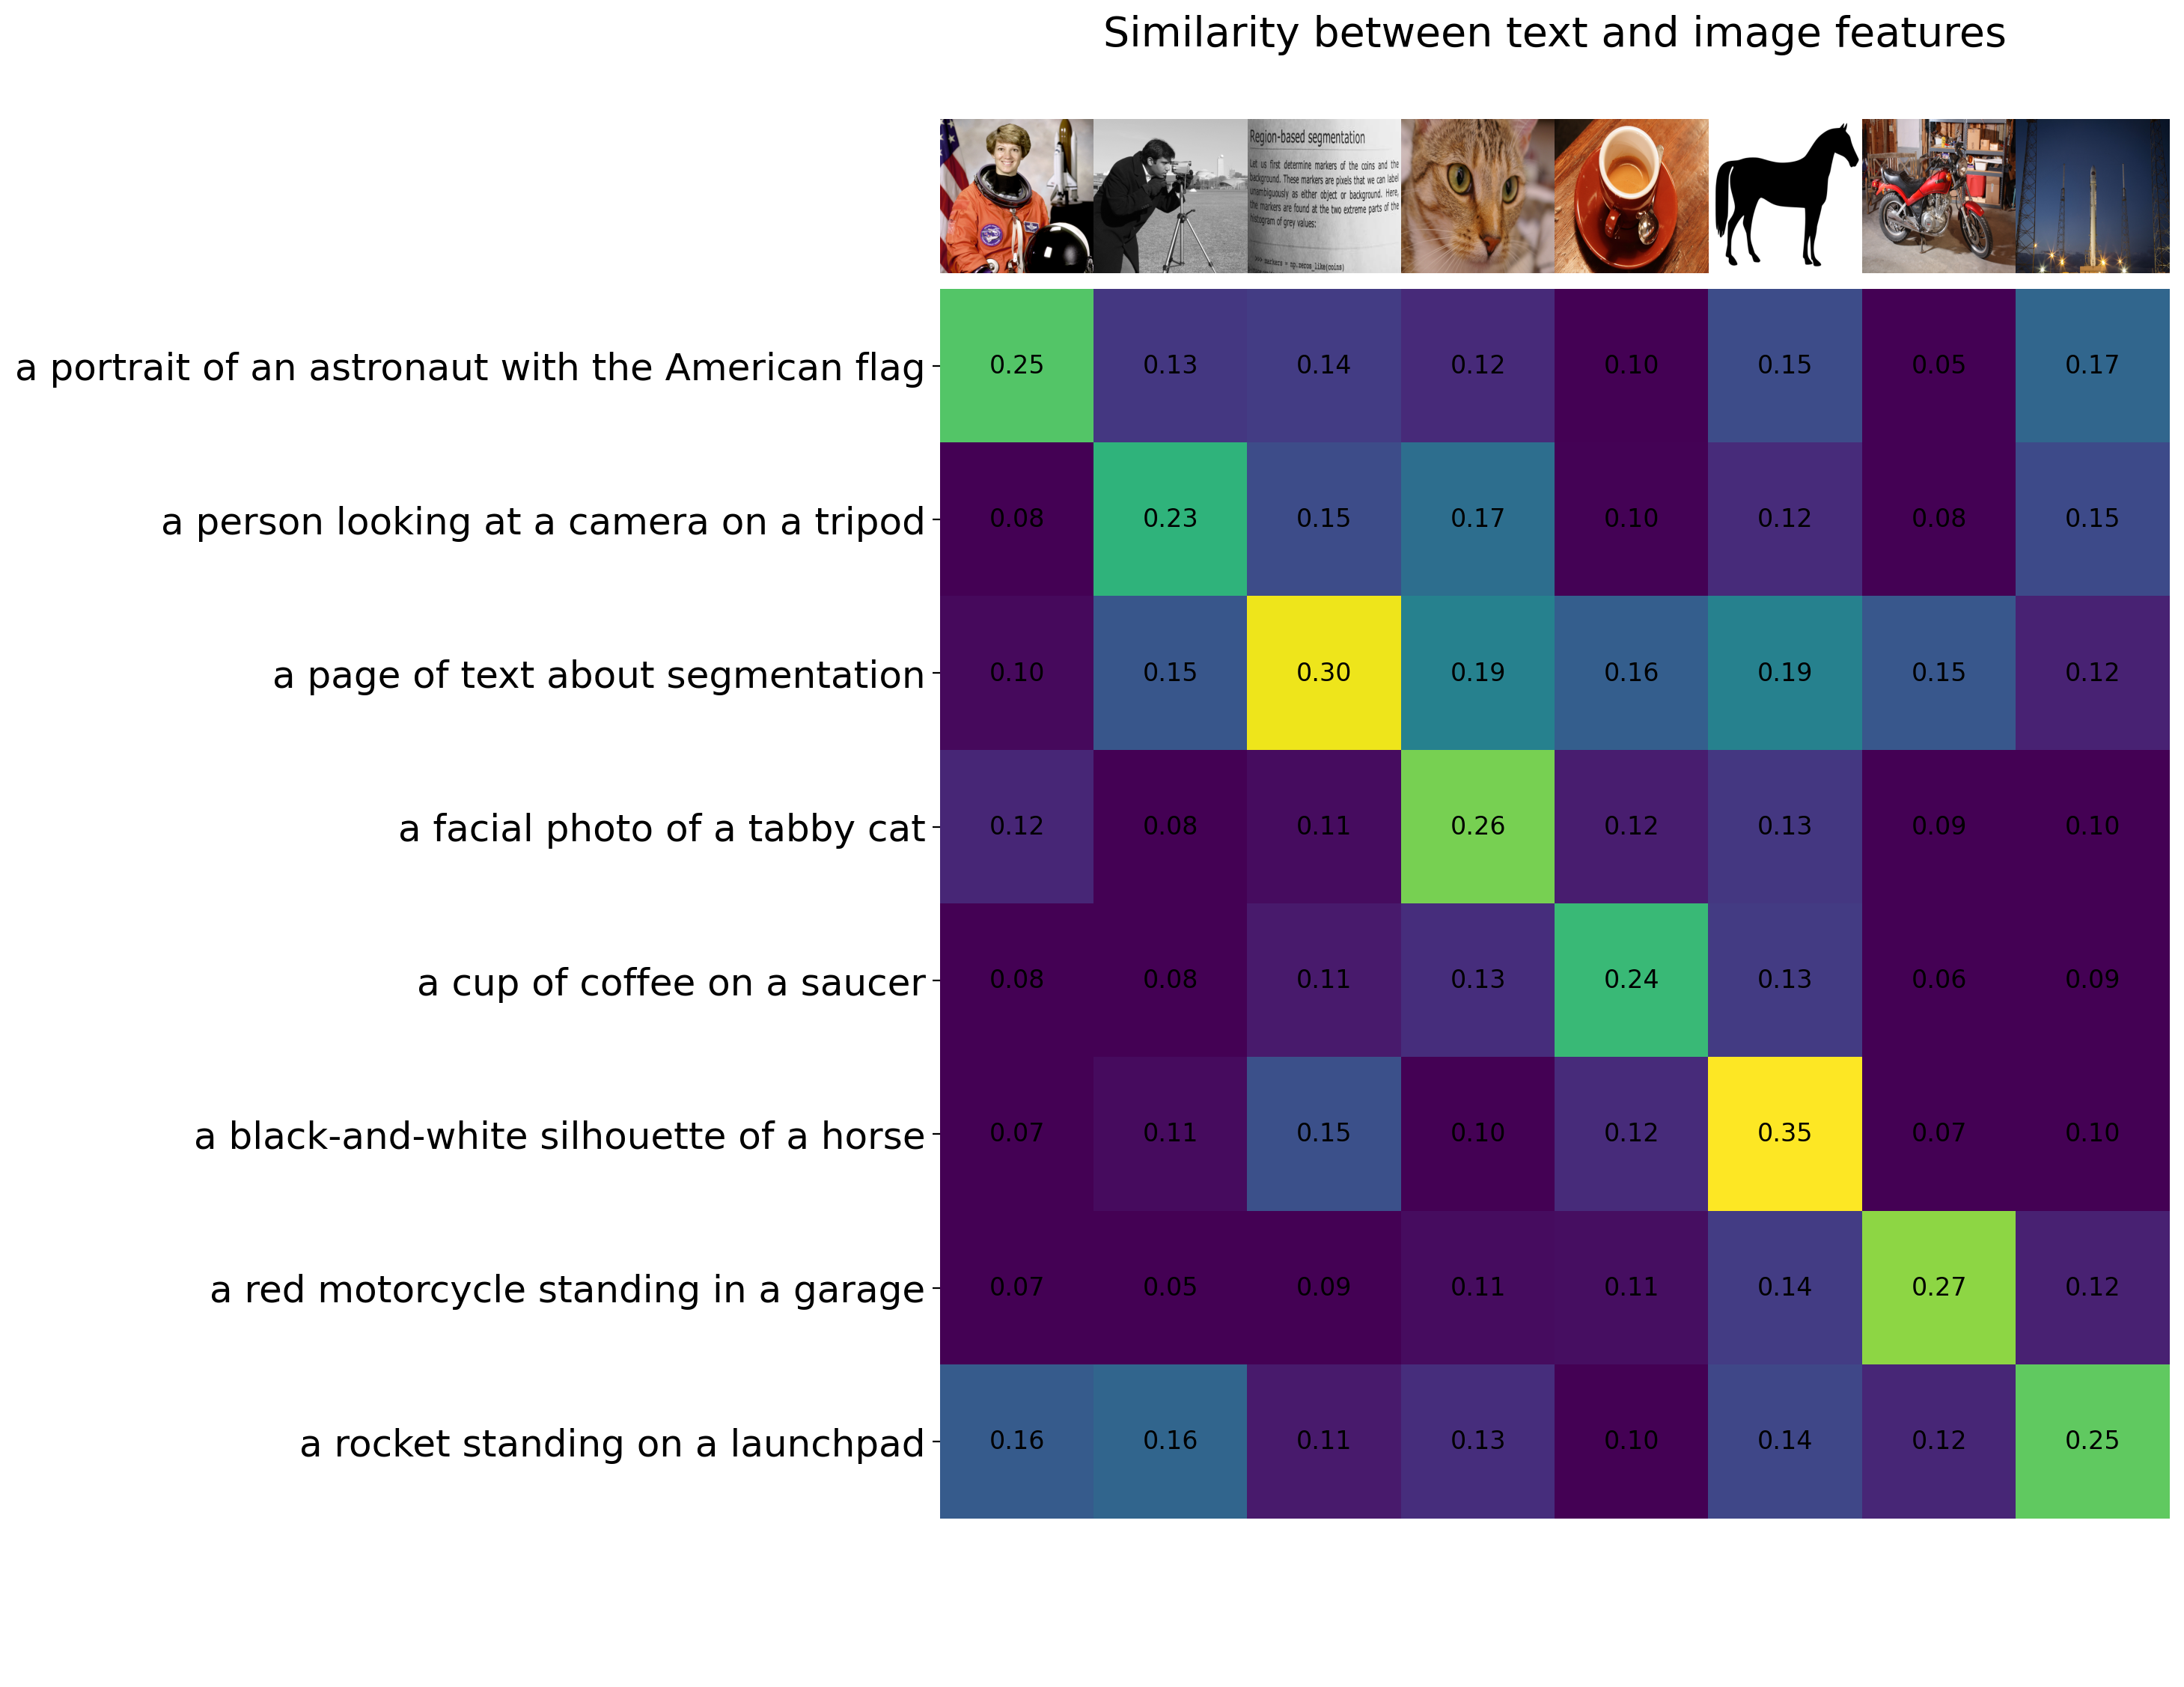

In [12]:
count = len(descriptions)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Similarity between text and image features", size=20)

As outlined in the paper, CLIP aims to maximize the similarity between the embeddings of image and text pairs within a batch, while simultaneously minimize the similarity of embeddings for incorrect pairings. In the above results, it's observed that the cells along the diagonal line exhibit the highest values among their respective columns and rows.

## Zero-Shot Image Classification

With the CLIP model we can classify images using the similarity as the logits to the softmax operation. The textual descriptions for images are generated using the labels from the [CIFAR-100](https://paperswithcode.com/dataset/cifar-100) dataset. For simplicity, we leverage the features extracted from the 8 images in the previous section. Rather than predicting the probability of an image belonging to a particular label, we compute the similarity between the text and the image. Subsequently, we retrieve the top k labels (set to 5 in the following code) associated with the highest probabilities.

In [13]:
from torchvision.datasets import CIFAR100

cifar100 = CIFAR100(os.path.expanduser("~/.cache"), transform=preprocess, download=True)

Files already downloaded and verified



Check the labels in the CIFAR-100 dataset.

In [ ]:
print(cifar100.classes)

```text
['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']
```

In [14]:
text_descriptions = [f"This is a photo of a {label}" for label in cifar100.classes]
text_tokens = clip.tokenize(text_descriptions).cuda()

In [15]:
# Calculate the similarity 
with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

# Scales logits into probabilities
text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
# Retrieve the top five labels with the highest probabilities for each image.
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

Display the results and you can see each image is classified properly. It's important to note that explicit `horse` and `cat` labels are not included within the CIFAR-100 dataset. Consequently, the CLIP model, tasked with labeling these images, categorizes them as `plain` and `tiger` respectively. These labels are chosen as the best match among the existing labels within the dataset, based on the visual characteristics observed by the model.

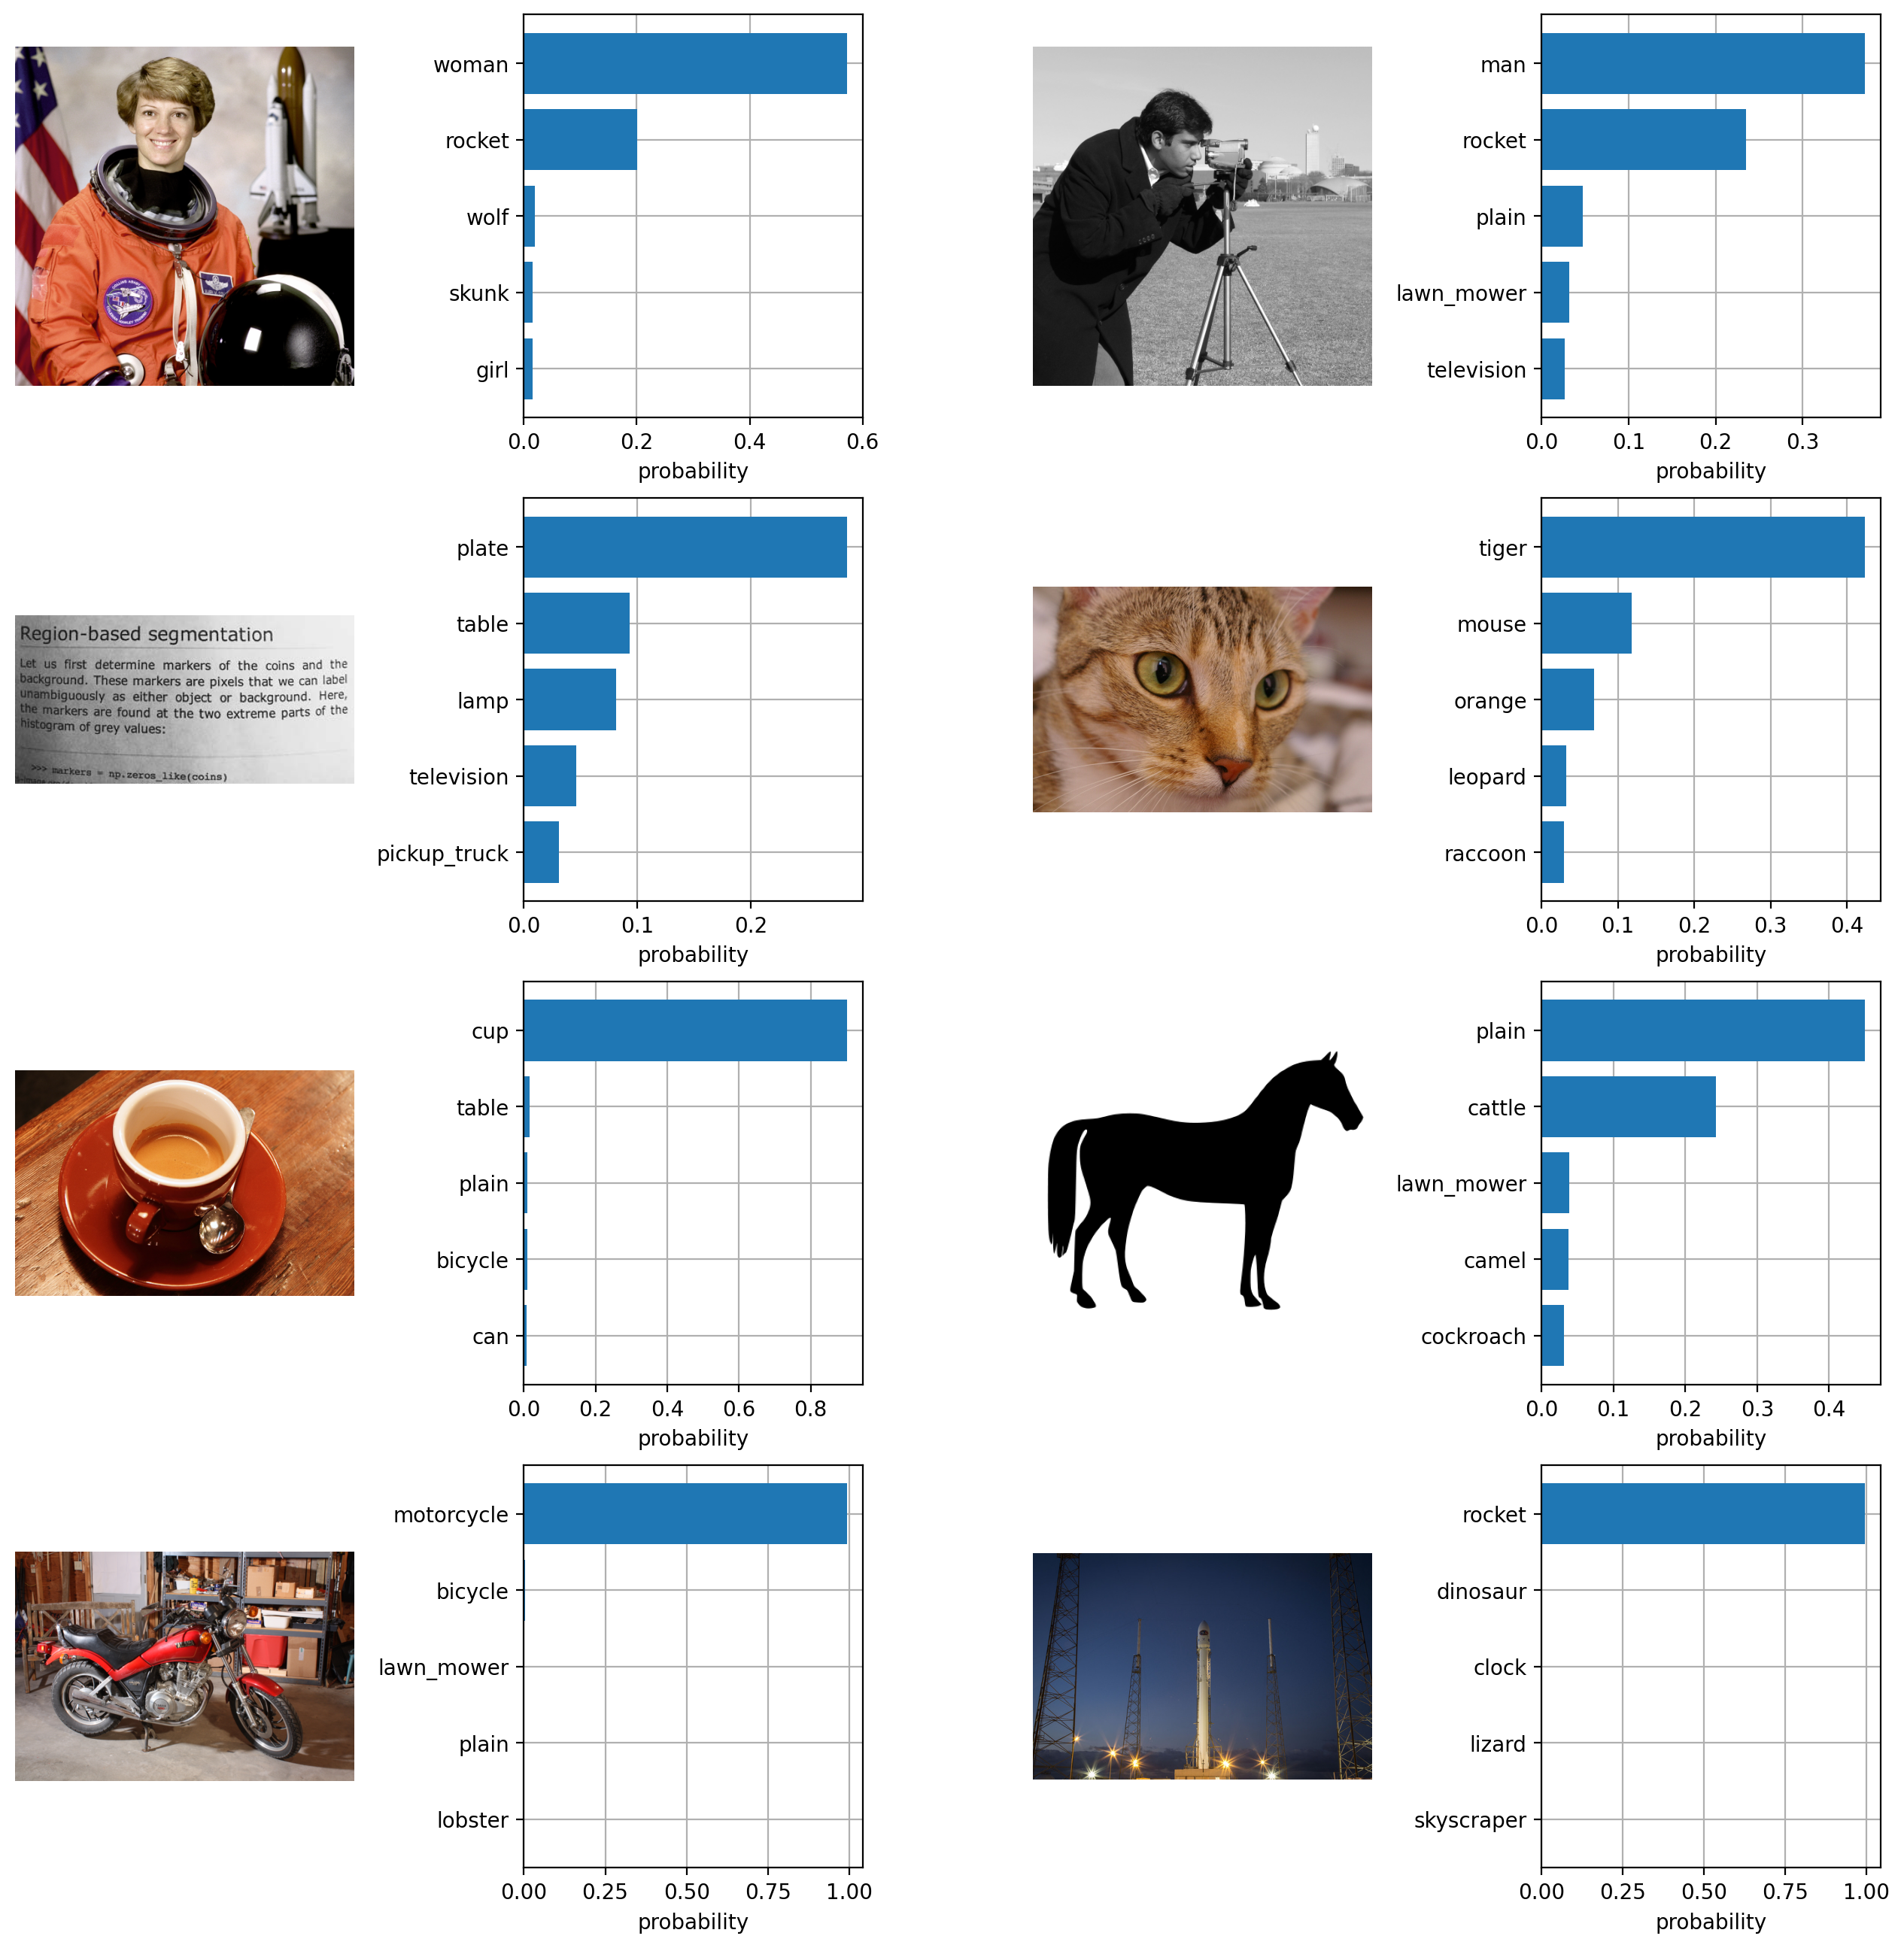

In [16]:
plt.figure(figsize=(16, 16))

for i, image in enumerate(original_images):
    plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(4, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [cifar100.classes[index] for index in top_labels[i].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()

## Disclaimers
Third-party content is licensed to you directly by the third party that owns the content and is not licensed to you by AMD. ALL LINKED THIRD-PARTY CONTENT IS PROVIDED “AS IS” WITHOUT A WARRANTY OF ANY KIND. USE OF SUCH THIRD-PARTY CONTENT IS DONE AT YOUR SOLE DISCRETION AND UNDER NO CIRCUMSTANCES WILL AMD BE LIABLE TO YOU FOR ANY THIRD-PARTY CONTENT. YOU ASSUME ALL RISK AND ARE SOLELY RESPONSIBLE FOR ANY DAMAGES THAT MAY ARISE FROM YOUR USE OF THIRD-PARTY CONTENT.